In [186]:
import numpy as np
import pandas as pd

In [187]:
import pandas as pd

train = pd.read_csv(
    './data/transactions_training_sept_oct_2023.csv',
    sep=";",               # séparateur de colonnes
    decimal=",",           # virgule comme séparateur décimal
    na_values="NA",        # valeur manquante
    parse_dates=["DATETIME_GMT"]  # convertir la colonne date
)


In [188]:

test = pd.read_csv(
    './data/transactions_unclassified_2023.csv',
    sep=";",               # séparateur de colonnes
    decimal=",",           # virgule comme séparateur décimal
    na_values="NA",        # valeur manquante
    parse_dates=["DATETIME_GMT"]  # convertir la colonne date
)


In [189]:
print(train["FLAG_FRAUD"].value_counts())


FLAG_FRAUD
0    79953
1       47
Name: count, dtype: int64


In [190]:
print(train["FLAG_FRAUD"].value_counts(normalize=True) * 100)


FLAG_FRAUD
0    99.94125
1     0.05875
Name: proportion, dtype: float64


In [191]:
train.isna().sum()

ID_TRX                          0
ID_CARD                         0
DATETIME_GMT                    0
AMOUNT                          0
Anomaly_amount_1                0
Anomaly_amount_2                0
Anomaly_amount_3                0
Anomaly_amount_4                0
Anomaly_amount_5                0
Anomaly_amount_6            43667
Anomaly_amount_7                0
Anomaly_amount_8                0
FLAG_BEHAVIOUR_Anomaly_1        0
FLAG_BEHAVIOUR_Anomaly_2        0
FLAG_BEHAVIOUR_Anomaly_3        0
FLAG_BEHAVIOUR_Anomaly_4        0
FLAG_BEHAVIOUR_Anomaly_5        0
FLAG_BEHAVIOUR_Anomaly_6        0
FLAG_BEHAVIOUR_Anomaly7         0
FLAG_BEHAVIOUR_Anomaly_8        0
Anomaly_amount_9            19816
Population_Anomaly_1            0
Population_Anomaly_2            0
Population_Anomaly_3            0
Population_Anomaly_4            0
Population_Anomaly_5            0
Population_Anomaly_6            0
Population_Anomaly_7            0
Population_Anomaly_8            0
FLAG_FRAUD    

In [192]:
test.isna().sum()

ID_TRX                         0
ID_CARD                        0
DATETIME_GMT                   0
AMOUNT                         0
Anomaly_amount_1               0
Anomaly_amount_2               0
Anomaly_amount_3               0
Anomaly_amount_4               0
Anomaly_amount_5               0
Anomaly_amount_6            6333
Anomaly_amount_7               0
Anomaly_amount_8               0
FLAG_BEHAVIOUR_Anomaly_1       0
FLAG_BEHAVIOUR_Anomaly_2       0
FLAG_BEHAVIOUR_Anomaly_3       0
FLAG_BEHAVIOUR_Anomaly_4       0
FLAG_BEHAVIOUR_Anomaly_5       0
FLAG_BEHAVIOUR_Anomaly_6       0
FLAG_BEHAVIOUR_Anomaly7        0
FLAG_BEHAVIOUR_Anomaly_8       0
Anomaly_amount_9            2839
Population_Anomaly_1           0
Population_Anomaly_2           0
Population_Anomaly_3           0
Population_Anomaly_4           0
Population_Anomaly_5           0
Population_Anomaly_6           0
Population_Anomaly_7           0
Population_Anomaly_8           0
dtype: int64

In [193]:
def detect_outliers_iqr(df, col):
    # Conversion robuste en float avec gestion de virgules et valeurs manquantes
    values = df[col].astype(str).str.replace(",", ".").replace("NA", pd.NA)
    values = pd.to_numeric(values, errors="coerce")

    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Retourne les lignes du DataFrame dont la valeur est un outlier
    return df[(values < lower) | (values > upper)]


In [194]:
outliers = detect_outliers_iqr(train, 'Population_Anomaly_8')

In [195]:
for col in list(train.columns):
    outliers = detect_outliers_iqr(train, col)
    print(f"Nb d’outliers sur "+col+f": {len(outliers)}")


Nb d’outliers sur ID_TRX: 0
Nb d’outliers sur ID_CARD: 0
Nb d’outliers sur DATETIME_GMT: 0
Nb d’outliers sur AMOUNT: 7721
Nb d’outliers sur Anomaly_amount_1: 6869
Nb d’outliers sur Anomaly_amount_2: 7720
Nb d’outliers sur Anomaly_amount_3: 8099
Nb d’outliers sur Anomaly_amount_4: 7978
Nb d’outliers sur Anomaly_amount_5: 7983
Nb d’outliers sur Anomaly_amount_6: 3758
Nb d’outliers sur Anomaly_amount_7: 7029
Nb d’outliers sur Anomaly_amount_8: 7543
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_1: 3355
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_2: 2507
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_3: 10551
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_4: 8204
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_5: 5563
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_6: 5462
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly7: 10816
Nb d’outliers sur FLAG_BEHAVIOUR_Anomaly_8: 2
Nb d’outliers sur Anomaly_amount_9: 1154
Nb d’outliers sur Population_Anomaly_1: 7181
Nb d’outliers sur Population_Anomaly_2: 8181
Nb d’outliers sur Population_

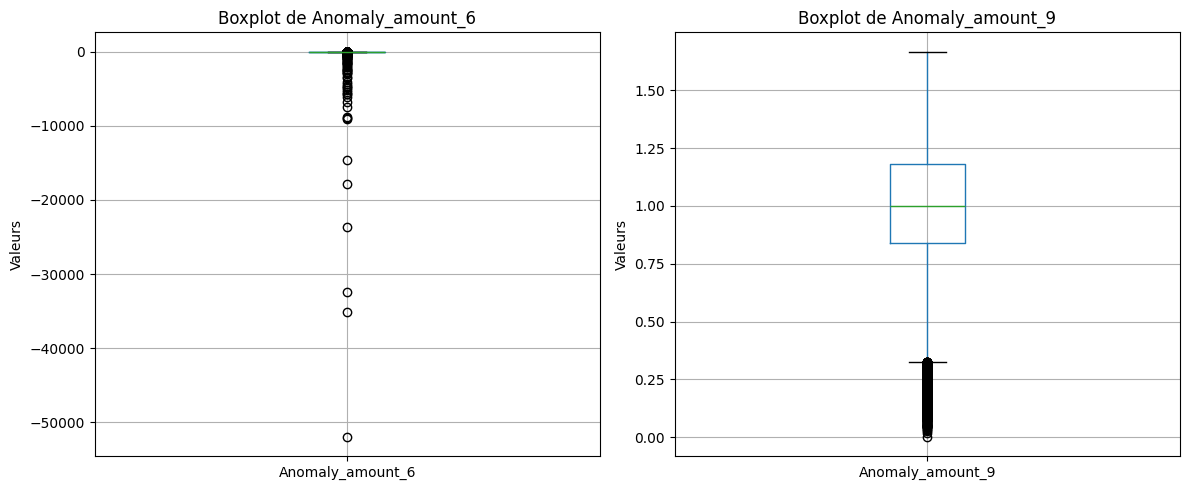

In [196]:
import matplotlib.pyplot as plt
import pandas as pd

# Colonnes à traiter
cols = ["Anomaly_amount_6", "Anomaly_amount_9"]

# Nettoyage : conversion en float (gestion virgules + 'NA')
for col in cols:
    train[col] = train[col].astype(str).str.replace(",", ".").replace("NA", pd.NA)
    train[col] = pd.to_numeric(train[col], errors="coerce")

# Tracer les boxplots séparément
plt.figure(figsize=(12, 5))

for i, col in enumerate(cols):
    plt.subplot(1, 2, i + 1)
    train.boxplot(column=col)
    plt.title(f"Boxplot de {col}")
    plt.ylabel("Valeurs")

plt.tight_layout()
plt.show()


In [197]:
train['Anomaly_amount_6'].isna().sum()/len(train['Anomaly_amount_6'])

np.float64(0.5458375)

In [198]:
train["ID_CARD"] = pd.to_numeric(train["ID_CARD"], errors="coerce")


Feature eng


In [199]:
# On trie par carte + date pour bien aligner les historiques
train = train.sort_values(by=["ID_CARD", "DATETIME_GMT"])

# Calcul du temps écoulé depuis la dernière transaction (en secondes)
train["time_since_last_txn"] = train.groupby("ID_CARD")["DATETIME_GMT"].diff().dt.total_seconds()

# Calcul de la différence d'amount depuis la dernière transaction
train["amount_diff_since_last_txn"] = train.groupby("ID_CARD")["AMOUNT"].diff()

train["hour"] = train["DATETIME_GMT"].dt.hour
train["dayofweek"] = train["DATETIME_GMT"].dt.dayofweek
train["is_night"] = train["hour"].apply(lambda h: 1 if h < 6 or h >= 22 else 0)

In [200]:
print(train['time_since_last_txn'].isna().sum())
print(train['amount_diff_since_last_txn'].isna().sum())

38194
38194


In [201]:
len(train['ID_CARD'].unique())

38194

In [202]:
train[train['FLAG_FRAUD']==1]

,ID_TRX,ID_CARD,DATETIME_GMT,AMOUNT,Anomaly_amount_1,Anomaly_amount_2,Anomaly_amount_3,Anomaly_amount_4,Anomaly_amount_5,Anomaly_amount_6,...,Population_Anomaly_5,Population_Anomaly_6,Population_Anomaly_7,Population_Anomaly_8,FLAG_FRAUD,time_since_last_txn,amount_diff_since_last_txn,hour,dayofweek,is_night
57241,199305873,29208234,2023-10-08 20:39:00,2990.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,-0.959100,-0.959031,-1.000000,-1.000000,1,NaN,NaN,20,6,0
38668,198342717,35508922,2023-10-02 04:09:00,2985.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959031,-0.958962,-1.000000,-1.000000,1,NaN,NaN,4,0,1
38667,198342725,35648166,2023-10-02 04:07:00,2980.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,-0.958963,-0.958893,-1.000000,-1.000000,1,NaN,NaN,4,0,1
60233,199460351,36732606,2023-10-10 04:09:00,2993.00,-1.000000,-1.000000,-1.000000,-1.000000,-0.908119,NaN,...,-0.959141,-0.959072,-0.310368,-1.000000,1,27300.0,-6.21,4,1,1
54362,199158533,38667195,2023-10-07 21:00:00,2.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-799.000000,...,60.145504,60.249184,-1.000000,-1.000000,1,2160.0,-1598.00,21,5,0
54337,199157152,38669723,2023-10-07 20:14:00,2990.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959100,-0.959031,-1.000000,-1.000000,1,NaN,NaN,20,5,0
76192,200294159,41137250,2023-10-15 20:37:00,2990.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959100,-0.959031,-1.000000,-1.000000,1,NaN,NaN,20,6,0
41438,198484911,41337403,2023-10-02 19:24:00,2985.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959031,-0.958962,-1.000000,-1.000000,1,NaN,NaN,19,0,0
57247,199306158,43220550,2023-10-08 20:46:00,2995.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,-0.959168,-0.959099,-1.000000,-1.000000,1,NaN,NaN,20,6,0
78986,200440696,43817886,2023-10-17 04:10:00,2995.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959168,-0.959099,-1.000000,-1.000000,1,NaN,NaN,4,1,1


In [203]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report


In [204]:
train[train['FLAG_FRAUD']==1]

,ID_TRX,ID_CARD,DATETIME_GMT,AMOUNT,Anomaly_amount_1,Anomaly_amount_2,Anomaly_amount_3,Anomaly_amount_4,Anomaly_amount_5,Anomaly_amount_6,...,Population_Anomaly_5,Population_Anomaly_6,Population_Anomaly_7,Population_Anomaly_8,FLAG_FRAUD,time_since_last_txn,amount_diff_since_last_txn,hour,dayofweek,is_night
57241,199305873,29208234,2023-10-08 20:39:00,2990.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,-0.959100,-0.959031,-1.000000,-1.000000,1,NaN,NaN,20,6,0
38668,198342717,35508922,2023-10-02 04:09:00,2985.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959031,-0.958962,-1.000000,-1.000000,1,NaN,NaN,4,0,1
38667,198342725,35648166,2023-10-02 04:07:00,2980.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,-0.958963,-0.958893,-1.000000,-1.000000,1,NaN,NaN,4,0,1
60233,199460351,36732606,2023-10-10 04:09:00,2993.00,-1.000000,-1.000000,-1.000000,-1.000000,-0.908119,NaN,...,-0.959141,-0.959072,-0.310368,-1.000000,1,27300.0,-6.21,4,1,1
54362,199158533,38667195,2023-10-07 21:00:00,2.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-799.000000,...,60.145504,60.249184,-1.000000,-1.000000,1,2160.0,-1598.00,21,5,0
54337,199157152,38669723,2023-10-07 20:14:00,2990.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959100,-0.959031,-1.000000,-1.000000,1,NaN,NaN,20,5,0
76192,200294159,41137250,2023-10-15 20:37:00,2990.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959100,-0.959031,-1.000000,-1.000000,1,NaN,NaN,20,6,0
41438,198484911,41337403,2023-10-02 19:24:00,2985.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959031,-0.958962,-1.000000,-1.000000,1,NaN,NaN,19,0,0
57247,199306158,43220550,2023-10-08 20:46:00,2995.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,-0.959168,-0.959099,-1.000000,-1.000000,1,NaN,NaN,20,6,0
78986,200440696,43817886,2023-10-17 04:10:00,2995.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,...,-0.959168,-0.959099,-1.000000,-1.000000,1,NaN,NaN,4,1,1


In [205]:

# 1. Séparation X / y
X = train.drop(columns=["FLAG_FRAUD","DATETIME_GMT"])
y = train["FLAG_FRAUD"].astype(int)  # au cas où c’est encore un str
weight = (y == 0).sum() / (y == 1).sum()

# Tri du dataset par date croissante
sorted_df = train.sort_values("DATETIME_GMT").reset_index(drop=True)

# Taille du split (20% en test)
split_idx = int(len(sorted_df) * 0.8)

# Séparation manuelle
train_df = sorted_df.iloc[:split_idx]
test_df  = sorted_df.iloc[split_idx:]

# Séparation X / y
X_train = train_df.drop(columns=["FLAG_FRAUD", "DATETIME_GMT"])
y_train = train_df["FLAG_FRAUD"].astype(int)

X_test = test_df.drop(columns=["FLAG_FRAUD", "DATETIME_GMT"])
y_test = test_df["FLAG_FRAUD"].astype(int)


In [206]:
X_train

,ID_TRX,ID_CARD,AMOUNT,Anomaly_amount_1,Anomaly_amount_2,Anomaly_amount_3,Anomaly_amount_4,Anomaly_amount_5,Anomaly_amount_6,Anomaly_amount_7,...,Population_Anomaly_4,Population_Anomaly_5,Population_Anomaly_6,Population_Anomaly_7,Population_Anomaly_8,time_since_last_txn,amount_diff_since_last_txn,hour,dayofweek,is_night
0,196339525,54309097,85.0,-0.352941,-0.576471,-0.715966,-0.753753,-0.746869,NaN,-0.294118,...,3.671102,3.693230,3.738034,-0.313725,-0.235294,NaN,NaN,0,6,1
1,196339531,37160392,370.0,-1.000000,-0.181622,-0.309009,-0.309009,-0.359459,NaN,-1.000000,...,-0.660150,-0.669171,-0.668452,0.428829,-0.041081,NaN,NaN,1,6,1
2,196339546,36562573,350.0,-0.434286,-0.577143,-0.611429,-0.703686,-0.468499,NaN,-0.531429,...,-0.640730,-0.650266,-0.649507,-0.321905,-0.481143,NaN,NaN,2,6,1
3,196339729,33066184,68.0,0.102941,0.272059,0.424632,0.314388,0.168108,NaN,0.535294,...,0.849182,0.800099,0.804010,-0.303922,0.447059,NaN,NaN,4,6,1
4,196339906,27058062,25.0,-0.200000,5.260000,3.200000,3.187879,2.830435,-2.900000,0.200000,...,4.029774,3.896270,3.906906,0.266667,0.160000,NaN,NaN,4,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,199659378,41928277,433.0,-1.000000,-1.000000,-1.000000,-0.196305,-0.043880,0.043880,-1.000000,...,-0.707188,-0.717573,-0.717094,-1.000000,-1.000000,NaN,NaN,7,3,0
63996,199659264,32326207,350.0,-0.754286,-0.734286,-0.263571,-0.353714,-0.335714,0.335714,-1.000000,...,-0.637750,-0.650597,-0.650005,-0.489524,-0.210857,1209120.0,264.0,7,3,0
63997,199659562,56818784,81.0,0.246914,-0.041152,0.092593,0.123457,0.123457,NaN,-0.493827,...,0.658819,0.614913,0.615201,-0.329218,-0.271605,522780.0,50.0,7,3,0
63998,199659582,26328646,28.0,-1.000000,0.357143,0.357143,0.357143,0.732143,NaN,-1.000000,...,3.528124,3.367536,3.374942,0.238095,0.585714,NaN,NaN,7,3,0


In [208]:


# 3. Modèle XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",  # évite warning
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01 ,
    scale_pos_weight=weight,
    random_state=4
)

# 4. Entraînement
model.fit(X_train, y_train)

# 5. Prédictions (avec seuil par défaut = 0.5)
y_pred = model.predict(X_test)

# 6. Évaluation
print(classification_report(y_test, y_pred, digits=4))
print("F1-score:", f1_score(y_test, y_pred))


y_train_pred = model.predict(X_train)

# Évaluation sur train
print("\n=== Performance sur le train set ===")
print(classification_report(y_train, y_train_pred, digits=4))
print("F1-score (train) :", f1_score(y_train, y_train_pred))




c:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:39:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9996     15982
           1     0.5909    0.7222    0.6500        18

    accuracy                         0.9991     16000
   macro avg     0.7953    0.8608    0.8248     16000
weighted avg     0.9992    0.9991    0.9992     16000

F1-score: 0.65

=== Performance sur le train set ===
              precision    recall  f1-score   support

           0     1.0000    0.9995    0.9998     63971
           1     0.5000    1.0000    0.6667        29

    accuracy                         0.9995     64000
   macro avg     0.7500    0.9998    0.8332     64000
weighted avg     0.9998    0.9995    0.9996     64000

F1-score (train) : 0.6666666666666666


In [210]:
# 3. Modèle XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",  # évite warning
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01 ,
    scale_pos_weight=weight,
    random_state=4
)

# 4. Entraînement
model.fit(X_train, y_train)

# 5. Prédictions (avec seuil par défaut = 0.5)
y_pred = model.predict(X_test)

# 6. Évaluation
print(classification_report(y_test, y_pred, digits=4))
print("F1-score:", f1_score(y_test, y_pred))


y_train_pred = model.predict(X_train)

# Évaluation sur train
print("\n=== Performance sur le train set ===")
print(classification_report(y_train, y_train_pred, digits=4))
print("F1-score (train) :", f1_score(y_train, y_train_pred))




c:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:39:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9996     15982
           1     0.5909    0.7222    0.6500        18

    accuracy                         0.9991     16000
   macro avg     0.7953    0.8608    0.8248     16000
weighted avg     0.9992    0.9991    0.9992     16000

F1-score: 0.65

=== Performance sur le train set ===
              precision    recall  f1-score   support

           0     1.0000    0.9995    0.9998     63971
           1     0.5000    1.0000    0.6667        29

    accuracy                         0.9995     64000
   macro avg     0.7500    0.9998    0.8332     64000
weighted avg     0.9998    0.9995    0.9996     64000

F1-score (train) : 0.6666666666666666
